In [ ]:
import pandas as pd
import numpy as np
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/VNNV_Pyvi.csv')
df

,Text,Label
0,ban quản_lý dự_án oda thành_phố thơ tết nguyên...,Chính trị Xã hội
1,luật lao_động thành_phố thơ tổ_chức gắn biển c...,Chính trị Xã hội
2,chiều nguyễn đình chiểu thường_trực hội_đồng n...,Chính trị Xã hội
3,sở lao_động thương_binh xã_hội thành_phố thơ p...,Chính trị Xã hội
4,vĩnh_thạnh đầu ủy đảng huyện quan_tâm lãnh_đạo...,Chính trị Xã hội
...,...,...
14498,hôm_qua hà nội phòng cảnh_sát phòng_chống tội_...,Pháp luật
14499,tình_hình giá_cả mặt_hàng lương_thực thực_phẩm...,Pháp luật
14500,thông_tin công_an nguyễn trí sinh tạm giam cáo...,Pháp luật
14501,hôm_qua ngày_tháng công_an thành_phố long xuyê...,Pháp luật


In [ ]:
df = df.dropna(subset=['Text'])

In [ ]:
df.describe()

,Text,Label
count,14503,14503
unique,14251,11
top,chương hứng_khởi trường đại_học hùng vương thà...,Chính trị Xã hội
freq,4,1457


### Set Up

In [ ]:
!pip install transformers

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel
from transformers import get_linear_schedule_with_warmup, logging

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

In [ ]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(86)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 6
N_SPLITS = 5

In [ ]:
!pip3 install torchvision

In [ ]:
# torch.cuda.get_device_name(0)

### Load Data

In [ ]:
train_ratio = 0.7
test_ratio = 0.2
valid_ratio = 0.1

train_df, temp_df = train_test_split(df, test_size=1 - train_ratio, random_state=42)
test_df, valid_df = train_test_split(temp_df, test_size=valid_ratio / (test_ratio + valid_ratio), random_state=42)

# Reset the index of the split DataFrames
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

# Print the shapes of the split DataFrames
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Validation shape:", valid_df.shape)

Train shape: (10152, 2)
Test shape: (2900, 2)
Validation shape: (1451, 2)


In [ ]:
# We will use Kfold later
train_df = pd.concat([train_df, valid_df], ignore_index=True)
skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.Label)):
    train_df.loc[val_, "kfold"] = fold

In [ ]:
train_df.sample(5)

,Text,Label,kfold
4385,tiếp_tục thông_tin thị_trường hàng_hóa kết_thú...,Kinh tế,1.0
8972,nữ võ_sĩ trương thị kim tuyền vận_động_viên ta...,Văn hóa,3.0
7549,cảnh_sát hồng kông mùng bắt tổ_chức thắp nến c...,Thế giới,3.0
3090,bà_con nông_dân dịch_tả heo châu phi bùng_phát...,Nông nghiệp,1.0
6831,arsenal thất_bại thanh_lý nicholas vp cbs câu ...,Thể thao,3.0


In [ ]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11603 entries, 0 to 11602
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Text    11603 non-null  object 
 1   Label   11603 non-null  object 
 2   kfold   11603 non-null  float64
dtypes: float64(1), object(2)
memory usage: 272.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    2900 non-null   object
 1   Label   2900 non-null   object
dtypes: object(2)
memory usage: 45.4+ KB


(None, None)

**=> No Missing Values**

<Axes: xlabel='Label', ylabel='count'>

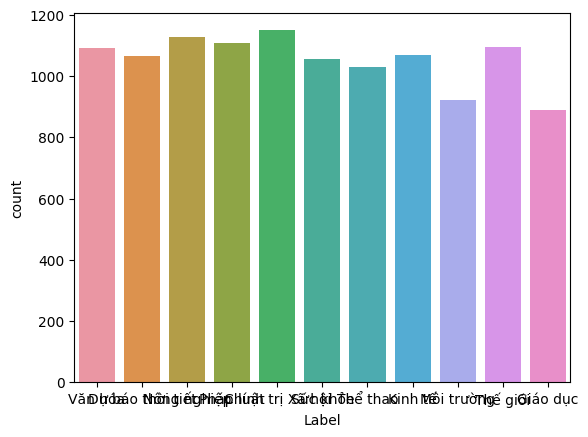

In [ ]:
sns.countplot(x='Label', data=train_df)

**=> Imbalanced labels! But We still want to classify 7 classes**

### DataLoader

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

In [ ]:
tokenizer

PhobertTokenizer(name_or_path='vinai/phobert-base', vocab_size=64000, model_max_length=256, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True)

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=256):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    def labelencoder(self,text):
        if text =='Chính trị Xã hội':
            return 0
        elif text =='Dự báo thời tiết':
            return 1
        elif text =='Kinh tế':
            return 2
        elif text =='Môi trường':
            return 3
        elif text =='Nông nghiệp':
            return 4
        elif text =='Pháp luật':
            return 5
        elif text =='Sức khỏe':
            return 6
        elif text =='Thế giới':
            return 7
        elif text =='Thể thao':
            return 8
        elif text =='Văn hóa':
            return 9
        elif text =='Giáo dục':
            return 10


    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row['Text']
        text = ' '.join(simple_preprocess(text))
        label = self.labelencoder(row['Label'])

        return text, label

**BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length.**

Text(0.5, 9.444444444444438, 'Token Count')

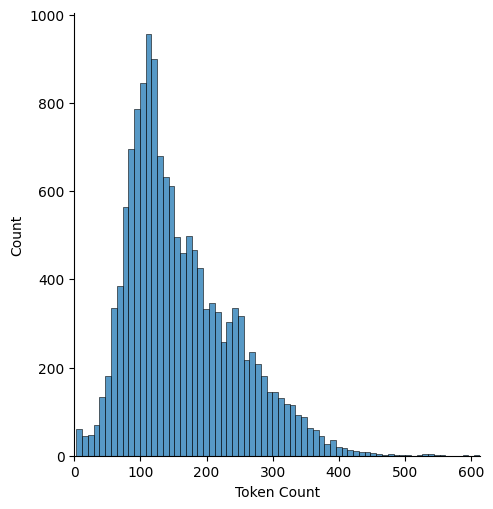

In [ ]:
# Distribution of length of Sentence
all_data = train_df.Text.tolist() + test_df.Text.tolist()
all_data = [' '.join(simple_preprocess(text)) for text in all_data]
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

**=> Choose a maximum of length of 50 is safe.**

### Model

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

In [ ]:
model = SentimentClassifier(n_classes=11)
print(model)

SentimentClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): La

### Train & Eval Function

In [ ]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval(test_data = False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())

    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)

In [ ]:
# Add these lines to initialize empty lists for accuracy and loss collection
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Modify train() function to collect accuracy and loss during training
def train(model, criterion, optimizer, train_loader):
    # Existing code...
    for data in train_loader:
        # Existing code...

    train_accuracy = correct.double() / len(train_loader.dataset)
    train_loss = np.mean(losses)

    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    print(f'Train Accuracy: {train_accuracy} Loss: {train_loss}')

# Modify eval() function to collect accuracy and loss during evaluation
def eval(test_data=False):
    # Existing code...

    if test_data:
        test_accuracy = correct.double() / len(test_loader.dataset)
        test_loss = np.mean(losses)
        test_accuracies.append(test_accuracy)
        test_losses.append(test_loss)

        print(f'Test Accuracy: {test_accuracy} Loss: {test_loss}')
        return test_accuracy
    else:
        valid_accuracy = correct.double() / len(valid_loader.dataset)
        valid_loss = np.mean(losses)
        valid_accuracies.append(valid_accuracy)
        valid_losses.append(valid_loss)

        print(f'Valid Accuracy: {valid_accuracy} Loss: {valid_loss}')
        return valid_accuracy


### Training with K-Fold

In [ ]:
max_sentence_length = df['Text'].apply(len).max()

print("Max sentence length:", max_sentence_length)

Max sentence length: 3868


In [ ]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    train_dataset = SentimentDataset(df_train, tokenizer, max_len=256)
    valid_dataset = SentimentDataset(df_valid, tokenizer, max_len=256)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=3)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=3)

    return train_loader, valid_loader

In [ ]:
path = '/content/drive/MyDrive/model/32 - 250 - 5e-5'

In [ ]:
for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = prepare_loaders(train_df, fold=fold)
    model = SentimentClassifier(n_classes=11).to(device)
    criterion = nn.CrossEntropyLoss()
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 16, 32
    optimizer = AdamW(model.parameters(), lr=2e-5)

    lr_scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=0,
                num_training_steps=len(train_loader)*EPOCHS
            )
    best_acc = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print('-'*30)

        train(model, criterion, optimizer, train_loader)
        val_acc = eval()

        if val_acc > best_acc:
            model_filename = f'phobert_fold{fold+1}.pth'
            model_path = os.path.join(path, model_filename)
            torch.save(model.state_dict(), model_path)
            # torch.save(model.state_dict(), f'phobert_fold{fold+1}.pth')
            best_acc = val_acc

-----------Fold: 1 ------------------
Epoch 1/6
------------------------------


In [ ]:
class_names =['Chính trị Xã hội', 'Dự báo thời tiết', 'Kinh tế',
                     'Môi trường', 'Nông nghiệp', 'Pháp luật', 'Sức khỏe',
                     'Thế giới', 'Thể thao', 'Văn hóa', 'Giáo dục']

In [ ]:
def test(data_loader):
    models = []
    for fold in range(skf.n_splits):
        model = SentimentClassifier(n_classes=11)
        model.to(device)

        model_filename = f'phobert_fold{fold+1}.pth'
        model_path = os.path.join(path, model_filename)
        model.load_state_dict(torch.load(model_path))

        #model.load_state_dict(torch.load(f'phobert_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)

        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)

    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts, target_names=class_names))
    # print(classification_report(real_values, predicts))
    return real_values, predicts

In [ ]:
test_dataset = SentimentDataset(test_df, tokenizer, max_len=120)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
real_values, predicts = test(test_loader)

                  precision    recall  f1-score   support

Chính trị Xã hội       0.94      0.97      0.96       307
Dự báo thời tiết       1.00      0.99      1.00       252
         Kinh tế       0.98      0.98      0.98       238
      Môi trường       0.95      0.95      0.95       245
     Nông nghiệp       0.97      0.92      0.95       277
       Pháp luật       0.93      0.95      0.94       259
        Sức khỏe       0.94      0.94      0.94       257
        Thế giới       0.94      0.98      0.96       261
        Thể thao       1.00      0.99      0.99       283
         Văn hóa       0.95      0.90      0.92       279
        Giáo dục       0.96      0.97      0.97       242

        accuracy                           0.96      2900
       macro avg       0.96      0.96      0.96      2900
    weighted avg       0.96      0.96      0.96      2900



### Heatmap between Predict and Ground Truth

In [ ]:
test_dataset = SentimentDataset(test_df, tokenizer, max_len=256)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)
real_values, predicts = test(test_loader)

                  precision    recall  f1-score   support

Chính trị Xã hội       0.99      0.97      0.98       307
Dự báo thời tiết       1.00      1.00      1.00       252
         Kinh tế       0.98      0.98      0.98       238
      Môi trường       0.97      0.96      0.97       245
     Nông nghiệp       0.99      0.99      0.99       277
       Pháp luật       0.96      0.95      0.96       259
        Sức khỏe       0.98      0.98      0.98       257
        Thế giới       0.96      0.98      0.97       261
        Thể thao       1.00      0.99      0.99       283
         Văn hóa       0.95      0.96      0.95       279
        Giáo dục       0.98      0.98      0.98       242

        accuracy                           0.98      2900
       macro avg       0.98      0.98      0.98      2900
    weighted avg       0.98      0.98      0.98      2900



### Heatmap between Predict and Ground Truth

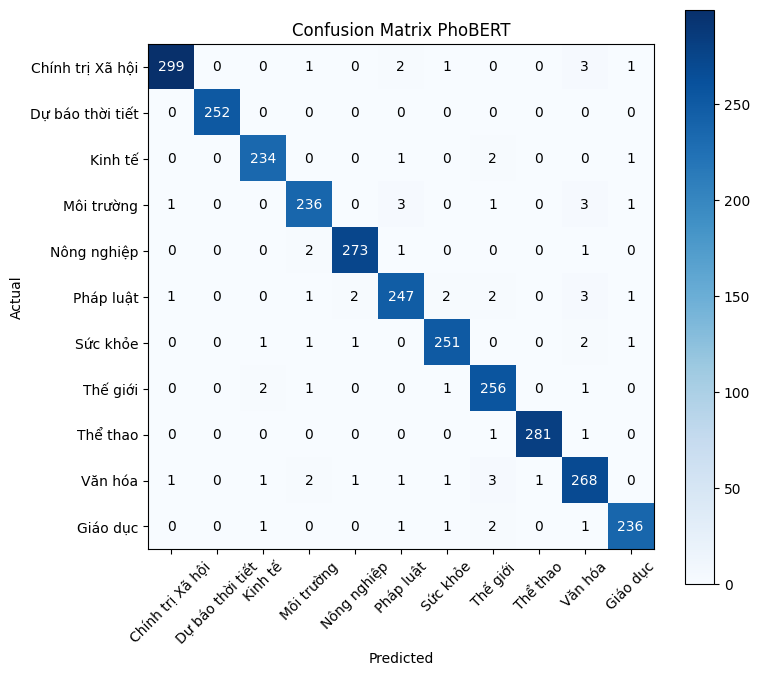

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix PhoBERT')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

    plt.tight_layout()
    plt.show()

# Call this function with your real values and predicted values

plot_confusion_matrix(real_values, predicts, class_names)


### Visualize Wrong Predicted Label

In [ ]:
def check_wrong(real_values, predicts):
    wrong_arr = []
    wrong_label = []
    for i in range(len(predicts)):
        if predicts[i] == real_values[i]:
            wrong_arr.append(i)
            wrong_label.append(predicts[i])
    return wrong_arr, wrong_label

for i in range(15):
    print('-'*50)
    wrong_arr, wrong_label = check_wrong(real_values, predicts)
    print(test_df.iloc[wrong_arr[i]].Text)
    print(f'Predicted: ({class_names[wrong_label[i]]}) --vs-- Real label: ({class_names[real_values[wrong_arr[i]]]})')

### Inference

In [ ]:
def infer(text, tokenizer, max_len=256):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)

    print(f'Text: {text}')
    print(f'Sentiment: {class_names[y_pred]}')

### References:

* https://github.com/VinAIResearch/PhoBERT

* https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/


* https://www.kaggle.com/code/shoheiazuma/tweet-sentiment-roberta-pytorch/notebook#Model

* https://skimai.com/fine-tuning-bert-for-sentiment-analysis/